In [27]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

In [2]:
device = 'cuda:1'

In [3]:
def forward_maha(xx, mean, invcov):
    """
    mean: [1, D, K]
    invcov: [D, D]
    """
    z = xx.unsqueeze(-1) - mean
    op1 = torch.einsum('ijk,jl->ilk', z, invcov)
    op2 = torch.einsum('ijk,ijk->ik', op1, z)  # [B, K]
    
    return torch.min(op2, dim=1).values
    
def forward_maha_dl(model, dataloader, mean, invcov):
    global device
    l_score = []
    for xx in tqdm(dataloader):
        
        out = model(xx['pixel_values'].to(device), output_hidden_states=True)
        out = out.hidden_states[-1][:,0,:]
        out = model.vit.layernorm(out)
        
        prelogit = out.detach().cpu()
        score = forward_maha(prelogit, mean, invcov)
        l_score.append(score)
    return torch.cat(l_score)

def get_prelogit(model, dl):
    global device
    l_pred = []
    for xx in tqdm(dl):
        with torch.no_grad():
            out = model(xx['pixel_values'].to(device), output_hidden_states=True)
            out = out.hidden_states[-1][:,0,:]
            out = model.vit.layernorm(out)
        l_pred.append(out.detach().cpu())
    return torch.cat(l_pred)

In [2]:
# ! ls finetune-cifar-10

In [24]:
l_ckpt_dir = ['checkpoint-352', 'checkpoint-704', 'checkpoint-1056', 
'checkpoint-1408', 'checkpoint-1760', 'checkpoint-2112', 'checkpoint-2464',  
  'checkpoint-2816', 'checkpoint-3168', 'checkpoint-3520']

In [4]:
import sys
sys.path.append('../')
from utils import roc_btw_arr

In [11]:
from datasets import load_dataset

train_ds, test_ds = load_dataset('cifar10', split=['train', 'test'])
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
cifar100_ds = load_dataset('cifar100', split='test');

cifar10_train_ds = load_dataset('cifar10', split='train')

svhn_ds = load_dataset('svhn', 'cropped_digits', split='test')

cifar10_train_label = torch.tensor([cifar10_train_ds[i]['label'] for i in range(len(cifar10_train_ds))])

  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [13]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [14]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms_svhn(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [15]:
# Set the transforms
train_ds.set_transform(train_transforms)

val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

cifar100_ds.set_transform(val_transforms)
cifar10_train_ds.set_transform(val_transforms)

svhn_ds.set_transform(val_transforms_svhn)

In [16]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

def collate_fn_cifar100(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["fine_label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=4)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=4)
cifar100_dataloader = DataLoader(cifar100_ds, collate_fn=collate_fn_cifar100, batch_size=4, num_workers=2)
cifar10_train_dataloader = DataLoader(cifar10_train_ds, collate_fn=collate_fn, batch_size=64, num_workers=2)

svhn_dataloader = DataLoader(svhn_ds, collate_fn=collate_fn, batch_size=64, num_workers=2)

In [17]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for i in sorted(l_ckpt_dir):
    print(i)

checkpoint-1056
checkpoint-1408
checkpoint-1760
checkpoint-2112
checkpoint-2464
checkpoint-2816
checkpoint-3168
checkpoint-352
checkpoint-3520
checkpoint-704


In [18]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"
run_name = f"finetune-cifar-10-epoch15"
num_train_epoch = 15

args = TrainingArguments(
    run_name,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epoch,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [19]:
from datasets import load_metric
# import evaluate
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [20]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [21]:
# outputs = trainer.predict(test_ds)

In [22]:
# outputs.metrics['test_accuracy']

In [25]:
l_ckpt_dir

['checkpoint-352',
 'checkpoint-704',
 'checkpoint-1056',
 'checkpoint-1408',
 'checkpoint-1760',
 'checkpoint-2112',
 'checkpoint-2464',
 'checkpoint-2816',
 'checkpoint-3168',
 'checkpoint-3520']

In [28]:
# ckpt_path = 'test-cifar-10/checkpoint-3375/pytorch_model.bin'
# for ckpt_idx in l_ckpt_dir:
for ckpt_idx in ['checkpoint-3520']:    
    print(ckpt_idx)
    ckpt_dir = f'finetune-cifar-10/{ckpt_idx}'
    ckpt_path = f'{ckpt_dir}/pytorch_model.bin'
    model.load_state_dict(torch.load(ckpt_path))
    model.eval();
    model.to(device);
    
    # outputs = trainer.predict(test_ds)
    # print(outputs)

    prelogit_file = f'{ckpt_dir}/prelogit.pkl'
    if os.path.isfile(prelogit_file):
        prelogit = torch.load(prelogit_file)
        print(f'loading {prelogit_file}...')
    else: 
        prelogit = get_prelogit(model, cifar10_train_dataloader)
        torch.save(prelogit, prelogit_file)

    '''mahalanobis statistics computation'''
    l_mean = []
    l_outer = []
    for k in range(10):
        subset_x = prelogit[cifar10_train_label == k]
        subset_mean = torch.mean(subset_x, dim=0, keepdim=True)
        # subset_outer = torch.cov(subset_x - subset_mean, correction=0) * len(subset_x)
        v = subset_x - subset_mean
        subset_outer = v.T.mm(v)
        l_mean.append(subset_mean)
        l_outer.append(subset_outer)
    pooled_cov = torch.sum(torch.stack(l_outer), dim=0) / len(prelogit)
    all_means = torch.stack(l_mean, dim=-1)
    invcov = torch.linalg.inv(pooled_cov)

    '''relative mahalanobis statistics'''
    whole_mean = torch.mean(prelogit, dim=0, keepdim=True)
    v = prelogit - whole_mean
    whole_cov = v.T.mm(v) / len(prelogit)
    whole_invcov = torch.linalg.inv(whole_cov)

    '''save'''
    torch.save({'all_means': all_means,
                'invcov': invcov,
                'whole_mean': whole_mean,
                'whole_invcov': whole_invcov}, f'{ckpt_dir}/maha-statistic.pkl')

    cifar10_maha = forward_maha_dl(model, test_dataloader, all_means, invcov)
    cifar100_maha = forward_maha_dl(model, cifar100_dataloader, all_means, invcov)
    print('CIFAR10 vs CIFAR100 MD AUROC', roc_btw_arr(cifar100_maha, cifar10_maha))

    rank = np.searchsorted(np.sort(cifar10_maha), cifar100_maha)
    print('CIFAR 100 min ranks', np.sort(rank)[:5])

    svhn_maha = forward_maha_dl(model, svhn_dataloader, all_means, invcov)
    print('CIFAR10 vs SVHN MD AUROC', roc_btw_arr(svhn_maha, cifar10_maha))

    rank = np.searchsorted(np.sort(cifar10_maha), svhn_maha)
    print('SVHN min ranks', np.sort(rank)[:5])
    #rank.min()
    print()

checkpoint-3520
loading finetune-cifar-10/checkpoint-3520/prelogit.pkl...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

CIFAR10 vs CIFAR100 MD AUROC 0.981038515
CIFAR 100 min ranks [ 2 13 19 44 94]


  0%|          | 0/407 [00:00<?, ?it/s]

CIFAR10 vs SVHN MD AUROC 0.9994976144744928
SVHN min ranks [7167 7378 7598 7952 8164]



## Example analysis

In [73]:
ckpt_idx = 'checkpoint-3168'
ckpt_dir = f'finetune-cifar-10/{ckpt_idx}'
ckpt_path = f'{ckpt_dir}/pytorch_model.bin'
model.load_state_dict(torch.load(ckpt_path))
model.eval();
model.to(device);

# outputs = trainer.predict(test_ds)
# print(outputs)

prelogit_file = f'{ckpt_dir}/prelogit.pkl'
if os.path.isfile(prelogit_file):
    prelogit = torch.load(prelogit_file)
    print(f'loading {prelogit_file}...')
else: 
    prelogit = get_prelogit(model, cifar10_train_dataloader)
    torch.save(prelogit, prelogit_file)

loading finetune-cifar-10/checkpoint-3168/prelogit.pkl...


In [74]:
d_maha = torch.load(f'{ckpt_dir}/maha-statistic.pkl')
all_means = d_maha['all_means']
invcov = d_maha['invcov']

In [75]:
cifar10_maha = forward_maha_dl(model, test_dataloader, all_means, invcov)
# cifar100_maha = forward_maha_dl(model, cifar100_dataloader, all_means, invcov)
# print('CIFAR10 vs CIFAR100 MD AUROC', roc_btw_arr(cifar100_maha, cifar10_maha))

# rank = np.searchsorted(np.sort(cifar10_maha), cifar100_maha)
# print('CIFAR 100 min ranks', np.sort(rank)[:5])

svhn_maha = forward_maha_dl(model, svhn_dataloader, all_means, invcov)
print('CIFAR10 vs SVHN MD AUROC', roc_btw_arr(svhn_maha, cifar10_maha))

rank = np.searchsorted(np.sort(cifar10_maha), svhn_maha)
print('SVHN min ranks', np.sort(rank)[:5])

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

CIFAR10 vs SVHN MD AUROC 0.9995287876459743
SVHN min ranks [7588 7703 7745 8074 8252]


* 가장 가까운

In [101]:
cifar10_test_prelogit = get_prelogit(model, test_dataloader)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [102]:
cifar10_test_prelogit.shape

torch.Size([10000, 768])

In [110]:
# pdist = ((prelogit.unsqueeze(1) - cifar10_test_prelogit.unsqueeze(0)) ** 2).sum(dim=2)
l_in_test_nndist = []
for i in tqdm(range(len(cifar10_test_prelogit))):
    xxx = cifar10_test_prelogit[[i]]
    l_in_test_nndist.append( ((prelogit - xxx) ** 2).sum(dim=1).min(dim=0).values )
    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [113]:
in_test_nndist = torch.tensor(l_in_test_nndist)

In [119]:
in_test_nndist = in_test_nndist[:,0]

(array([9.472e+03, 4.100e+02, 7.600e+01, 2.600e+01, 1.200e+01, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.3332694e-02, 4.4814267e+00, 8.9295206e+00, 1.3377615e+01,
        1.7825710e+01, 2.2273804e+01, 2.6721897e+01, 3.1169992e+01,
        3.5618088e+01, 4.0066181e+01, 4.4514275e+01], dtype=float32),
 <BarContainer object of 10 artists>)

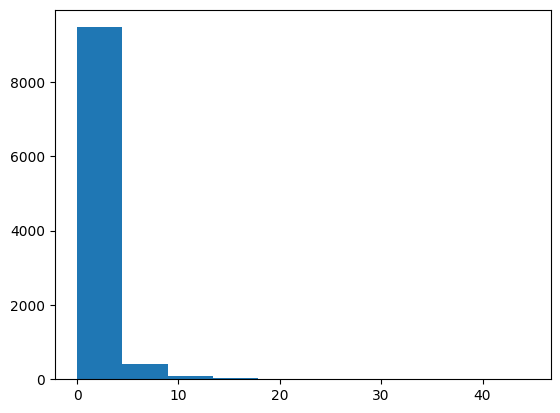

In [120]:
plt.hist(in_test_nndist.numpy(), bins=)

In [122]:
((prelogit - out.cpu()) ** 2).sum(dim=1).min(dim=0).values
    

tensor(5.5471)

In [140]:
((prelogit - out.cpu()) ** 2).sum(dim=1).min(dim=0).values
    

tensor(2.0486)

In [141]:
np.searchsorted(np.sort(in_test_nndist.numpy()), 2.0486)

7346

In [134]:
((prelogit - out.cpu()) ** 2).sum(dim=1).argmin()

tensor(39067)

In [76]:
np.argsort(rank)[:5]

array([14006, 13353, 24896,  4395, 24497])

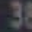

In [77]:
svhn_ds[14006]['image']

In [138]:
datum = svhn_ds[24896]['pixel_values'].unsqueeze(0).to(device)

In [87]:
subset_x = prelogit[cifar10_train_label==3]

In [88]:
aa = ((subset_x.unsqueeze(-1) - all_means) ** 2).mean(dim=1)

In [89]:
aa.mean(dim=0)

tensor([0.1173, 0.1147, 0.1117, 0.0047, 0.1130, 0.0963, 0.1124, 0.1145, 0.1159,
        0.1145])

In [90]:
aa.min(dim=0)

torch.return_types.min(
values=tensor([0.0430, 0.0817, 0.0300, 0.0012, 0.0227, 0.0026, 0.0346, 0.0411, 0.0233,
        0.0837]),
indices=tensor([ 783, 3537,  799, 1497, 3462, 3619,  715, 4031, 1445, 2664]))

In [139]:
'''distance to centroids'''
with torch.no_grad():
    out = model(datum, output_hidden_states=True)
    out = out.hidden_states[-1][:,0,:]
    out = model.vit.layernorm(out)

for i in range(10):
    print(((all_means[:,:,i] - out.cpu()) ** 2).mean())

tensor(0.0025)
tensor(0.1119)
tensor(0.1135)
tensor(0.1167)
tensor(0.1160)
tensor(0.1127)
tensor(0.1123)
tensor(0.1152)
tensor(0.1068)
tensor(0.1092)


In [104]:
np.argsort(rank)[:5]

array([24896, 13353, 24497,  7549, 16564])

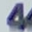

In [78]:
svhn_ds[24896]['image']

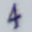

In [78]:
svhn_ds[13353]['image']

In [79]:
svhn_maha[24896]

tensor(876.5606)

In [107]:
svhn_maha[13353]

tensor(883.3958)

In [108]:
svhn_maha[24497]

tensor(983.8606)

In [157]:
datum = svhn_ds[13353]['pixel_values'].unsqueeze(0).to(device)

In [192]:
from torchvision.transforms.functional import hflip, affine, invert

In [199]:
datum2 = affine(svhn_ds[13353]['pixel_values'], 90,(0,0),1,0).unsqueeze(0).to(device)
# datum2 = invert(svhn_ds[13353]['pixel_values']).unsqueeze(0).to(device)

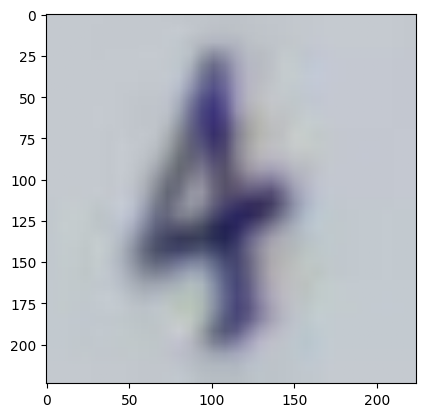

In [202]:
plt.imshow((datum[0].permute(1,2,0).cpu() * 0.5 +0.5 ))

In [195]:
with torch.no_grad():
    out = model(datum2, output_hidden_states=True)
    out = out.hidden_states[-1][:,0,:]
    out = model.vit.layernorm(out)

In [196]:
for i in range(10):
    print(((all_means[:,:,i] - out.cpu()) ** 2).mean())

tensor(0.0197)
tensor(0.1221)
tensor(0.0996)
tensor(0.1103)
tensor(0.1097)
tensor(0.1113)
tensor(0.1105)
tensor(0.1142)
tensor(0.1090)
tensor(0.1137)


In [99]:
nn_dist = ((out.cpu() - prelogit) ** 2).mean(dim=1)

In [100]:
nn_dist.min()

tensor(0.0072)

In [93]:
torch.argsort(nn_dist)[:10]

tensor([16544, 10714, 35158, 28348, 15649, 40395, 42412, 36226, 25279,  9384])

In [94]:
torch.argsort(nn_dist)[-10:]

tensor([27802,  2476, 23044, 30719, 27313, 19868,  5030, 10674, 42994, 11926])

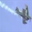

In [135]:
cifar10_train_ds[39067]['img']

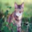

In [96]:
cifar10_train_ds[10714]['img']

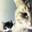

In [97]:
cifar10_train_ds[35158]['img']

## Eccentric inlier analysis

In [13]:
model.to('cuda:0');

In [136]:
cifar10_train_maha = forward_maha_dl(model, cifar10_train_dataloader, all_means, invcov)

  0%|          | 0/782 [00:00<?, ?it/s]

In [137]:
cifar10_train_maha[39067]

tensor(448.2420)

In [16]:
cifar10_train_maha.max()

tensor(16800.9668)

In [17]:
cifar10_train_maha.mean()

tensor(764.3541)

In [18]:
cifar10_train_maha.median()

tensor(609.8704)

In [19]:
sorted_idx = torch.argsort(cifar10_train_maha, descending=True)
print(sorted_idx[:5])
print(sorted_idx[-5:])

tensor([28310, 47220,  6661, 24594, 31044])
tensor([33813, 48839, 32008, 29809, 41074])


3 cat


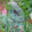

In [133]:
idx = 47220
print(cifar10_train_ds[idx]['label'], id2label[cifar10_train_ds[idx]['label']])
cifar10_train_ds[idx]['img']

9 truck


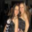

In [135]:
idx = 28310
print(cifar10_train_ds[idx]['label'], id2label[cifar10_train_ds[idx]['label']])
cifar10_train_ds[idx]['img']

1 automobile


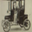

In [132]:
idx = 11538
print(cifar10_train_ds[idx]['label'], id2label[cifar10_train_ds[idx]['label']])
cifar10_train_ds[idx]['img']

9 truck


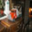

In [134]:
idx = 34809
print(cifar10_train_ds[idx]['label'], id2label[cifar10_train_ds[idx]['label']])
cifar10_train_ds[idx]['img']

1 automobile


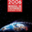

In [136]:
idx = 5129
print(cifar10_train_ds[idx]['label'], id2label[cifar10_train_ds[idx]['label']])
cifar10_train_ds[idx]['img']

5 dog


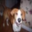

In [138]:
idx = 9103
print(cifar10_train_ds[idx]['label'], id2label[cifar10_train_ds[idx]['label']])
cifar10_train_ds[idx]['img']

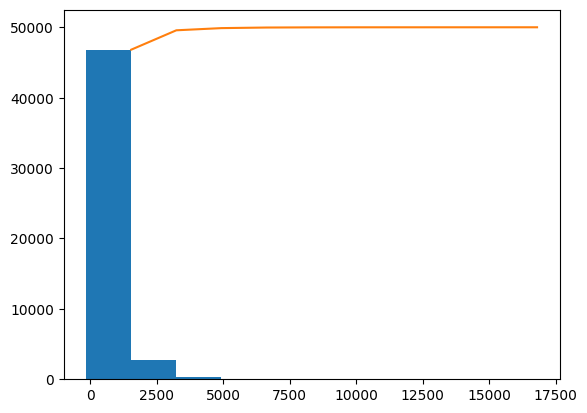

In [23]:
count, bins, c = plt.hist(cifar10_train_maha.numpy())
plt.plot(bins[1:], np.cumsum(count))

### robust estimation

In [40]:
cifar10_train_label = torch.tensor([cifar10_train_ds[i]['label'] for i in range(len(cifar10_train_ds))])

In [48]:
selected_idx = sorted_idx[1000:]

In [49]:
selected_prelogit = prelogit[selected_idx]

In [50]:
selected_label = cifar10_train_label[selected_idx]

In [51]:
'''mahalanobis statistics computation'''
l_mean = []
l_outer = []
for k in range(10):
    subset_x = selected_prelogit[selected_label == k]
    subset_mean = torch.mean(subset_x, dim=0, keepdim=True)
    # subset_outer = torch.cov(subset_x - subset_mean, correction=0) * len(subset_x)
    v = subset_x - subset_mean
    subset_outer = v.T.mm(v)
    l_mean.append(subset_mean)
    l_outer.append(subset_outer)
pooled_cov = torch.sum(torch.stack(l_outer), dim=0) / len(selected_prelogit)
selected_all_means = torch.stack(l_mean, dim=-1)
selected_invcov = torch.linalg.inv(pooled_cov)

In [52]:
cifar10_maha_typ = forward_maha_dl(model, test_dataloader, selected_all_means, selected_invcov)
cifar100_maha_typ = forward_maha_dl(model, cifar100_dataloader, selected_all_means, selected_invcov)

roc_btw_arr(cifar100_maha_typ, cifar10_maha_typ)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

0.9840303650000002

In [44]:
cifar10_maha_typ = forward_maha_dl(model, test_dataloader, selected_all_means, selected_invcov)
cifar100_maha_typ = forward_maha_dl(model, cifar100_dataloader, selected_all_means, selected_invcov)

roc_btw_arr(cifar100_maha_typ, cifar10_maha_typ)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

0.98407668

In [53]:
rank = np.searchsorted(np.sort(cifar10_maha_typ), cifar100_maha_typ)
rank.min()

733

In [45]:
rank = np.searchsorted(np.sort(cifar10_maha_typ), cifar100_maha_typ)
rank.min()

55

In [71]:
svhn_maha_typ = forward_maha_dl(model, svhn_dataloader, selected_all_means, selected_invcov)

roc_btw_arr(svhn_maha_typ, cifar10_maha_typ)

  0%|          | 0/407 [00:00<?, ?it/s]

0.9994338929010449

In [74]:
rank = np.searchsorted(np.sort(cifar10_maha_typ), svhn_maha_typ)
rank.min()

7243

In [101]:
all_means[0,:,0]

tensor([ 2.4356e-01,  1.4894e-01,  1.2839e-01, -6.1052e-02,  1.5404e-01,
        -3.7852e-01, -2.4515e-01,  7.9410e-02, -7.3658e-03, -1.8629e-01,
         2.2969e-01,  1.6255e-01, -2.9145e-01,  1.0398e-01, -3.9614e-02,
        -1.0957e-01, -7.7385e-02,  4.5932e-02, -5.6290e-04, -3.0793e-01,
         2.8626e-01, -4.7800e-02, -5.2784e-02,  3.0432e-01,  2.0490e-01,
        -1.8242e-01, -2.9659e-01,  1.0862e-01,  2.7107e-01, -3.3772e-01,
        -2.9363e-01,  6.8021e-02, -1.0338e-02, -2.1261e-01,  8.3830e-02,
        -4.1757e-02, -6.5709e-02, -1.6672e-01,  1.4233e-01,  6.7819e-02,
        -6.3437e-02,  2.6119e-01, -3.3096e-01, -1.3948e-01,  9.6189e-02,
        -1.7697e-01, -7.5740e-02,  1.2726e-01, -7.7552e-02,  9.9673e-02,
         3.2231e-01, -6.4960e-01, -9.9112e-02, -3.7929e-01,  1.7176e-01,
         2.0388e-01, -2.3977e-01, -1.0445e-01, -3.6889e-01, -3.5237e-01,
        -3.2354e-01, -2.1062e-03, -9.1476e-02, -2.5158e-01,  1.0491e-01,
         5.3120e-02, -3.3780e-01,  2.8274e-01,  6.6